# Copyright

<PRE>
Copyright (c) Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Assignment: RNN text generation with your favorite book


In [69]:
import numpy as np
import re
from collections import Counter
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

print("Num GPUs Available:", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available: 1


## 1. Dataset
- Download your favorite book from https://www.gutenberg.org/
- Split into training (80%) and validation (20%).

In [70]:
link = "https://www.gutenberg.org/"


with open("odyssey.txt", "r", encoding="utf-8") as f:
    text = f.read()
start = text.find("*** START OF THE PROJECT GUTENBERG EBOOK THE ODYSSEY ***")
end = text.find("*** END OF THE PROJECT GUTENBERG EBOOK THE ODYSSEY ***")

"""
with open("christmas.txt", "r", encoding="utf-8") as f:
    text = f.read()
start = text.find("*** START OF THE PROJECT GUTENBERG EBOOK A CHRISTMAS CAROL ***")
end = text.find("*** END OF THE PROJECT GUTENBERG EBOOK A CHRISTMAS CAROL ***")

with open("amontillado.txt", "r", encoding="utf-8") as f:
    text = f.read()
start = text.find("*** START OF THE PROJECT GUTENBERG EBOOK THE CASK OF AMONTILLADO ***")
end = text.find("*** END OF THE PROJECT GUTENBERG EBOOK THE CASK OF AMONTILLADO ***")
"""

text = text[start:end]
split = int(len(text) * 0.8)

train_text = text[:split]
val_text = text[split:]

print(len(train_text), len(val_text))
print(train_text[:100])

543112 135778
*** START OF THE PROJECT GUTENBERG EBOOK THE ODYSSEY ***




[Illustration]




The Odyssey

by Home


## 2. Preprocessing
- Convert text to lowercase.
- Remove punctuation (except basic sentence delimiters).
- Tokenize by words or characters (your choice).
- Build a vocabulary (map each unique word to an integer ID).

In [71]:
train_text = train_text.lower()
val_text = val_text.lower()

def clean_text(text):
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-z0-9\s\.\?\!]", "", text)
    return text

train_text = clean_text(train_text)
val_text = clean_text(val_text)

print(len(train_text), len(val_text))

print(train_text[:100])

# Tokenize by WORDS
train_tokens = train_text.split()
val_tokens = val_text.split()
word_counts = Counter(train_tokens)

vocab = {word: idx for idx, (word, _) in enumerate(word_counts.items())}
vocab_size = len(vocab)
id_to_word = {idx: word for word, idx in vocab.items()}
id_size = len(id_to_word)

530166 131171
 start of the project gutenberg ebook the odyssey  illustration the odyssey by homer rendered into e


## 3. Embedding Layer in Keras
Below is a minimal example of defining an `Embedding` layer:
```python
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=vocab_size,     # size of the vocabulary
    output_dim=128,           # embedding vector dimension
    input_length=sequence_length
)
```
- This layer transforms integer-encoded sequences (word IDs) into dense vector embeddings.

- Feed these embeddings into your LSTM or GRU OR 1D CNN layer.

In [72]:
train_ids = [vocab[word] for word in train_tokens if word in vocab]
val_ids = [vocab[word] for word in val_tokens if word in vocab]

sequence_length = 50

def create_sequences(ids, sequence_length):
    inputs = []
    targets = []
    for i in range(len(ids) - sequence_length):
        inp = ids[i:i + sequence_length]
        target = ids[i + sequence_length]
        inputs.append(inp)
        targets.append(target)
    return np.array(inputs), np.array(targets)

X_train, y_train = create_sequences(train_ids, sequence_length)
X_val, y_val = create_sequences(val_ids, sequence_length)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

print(f"Sample training sequence: {X_train[0]}")
print(f"Sample training target: {y_train[0]}")
print(f"Sample validation sequence: {X_val[0]}")
print(f"Sample validation target: {y_val[0]}")

X_train: (104236, 50)
y_train: (104236,)
X_val: (22948, 50)
y_val: (22948,)
Sample training sequence: [ 0  1  2  3  4  5  2  6  7  2  6  8  9 10 11 12 13 14  2 15  1 16 17 18
 19  2 20 21 22 23 24 25 22 23 26 25  2  6 27 28 27 29 27 30 27 31 27 32
 27 33]
Sample training target: 27
Sample validation sequence: [  96  116 1625   17  242  521 6050 1358  472  140 1057   23 7183    2
 7209 1060 2752 2271   67  906   74    2  275   91 1241   67 1249 1936
    8  102   67 1049 3227  125   83  273  494  194   67  702 4109    1
  111  112  182  105   74    2 1196 1040]
Sample validation target: 494


In [73]:
embedding_dim = 256

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)

print(f"Embedding Layer: input_dim={vocab_size}, output_dim={embedding_dim}")

Embedding Layer: input_dim=7992, output_dim=256


## 4. Model
- Implement an LSTM or GRU or 1D CNN-based language model with:
  - **The Embedding layer** as input.
  - At least **one recurrent layer** (e.g., `LSTM(256)` or `GRU(256)` or your custom 1D CNN).
  - A **Dense** output layer with **softmax** activation for word prediction.
- Train for about **5–10 epochs** so it can finish in approximately **2 hours** on a standard machine.


In [74]:
model = Sequential()
model.add(Input(shape=(sequence_length,)))
model.add(embedding_layer)
model.add(LSTM(units=256))
model.add(Dense(units=vocab_size, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 50, 256)        │     2,045,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7992)           │     2,053,944 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,625,208 (17.64 MB)

 Trainable params: 4,625,208 (17.64 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Training & Evaluation
- **Monitor** the loss on both training and validation sets.
- **Perplexity**: a common metric for language models.
  - It is the exponent of the average negative log-likelihood.
  - If your model outputs cross-entropy loss `H`, then `perplexity = e^H`.
  - Try to keep the validation perplexity **under 50** if possible. If you have higher value (which is possible) try to draw conclusions, why doesn't it decrease to a lower value.

Epoch 1/10
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - accuracy: 0.0640 - loss: 6.5493 - val_accuracy: 0.1215 - val_loss: 5.6654
Epoch 2/10
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - accuracy: 0.1279 - loss: 5.4414 - val_accuracy: 0.1437 - val_loss: 5.4104
Epoch 3/10
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - accuracy: 0.1587 - loss: 4.8807 - val_accuracy: 0.1515 - val_loss: 5.3544
Epoch 4/10
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - accuracy: 0.1919 - loss: 4.4025 - val_accuracy: 0.1540 - val_loss: 5.3921
Epoch 5/10
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - accuracy: 0.2272 - loss: 3.9751 - val_accuracy: 0.1530 - val_loss: 5.4945
Epoch 6/10
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - accuracy: 0.2733 - loss: 3.5671 - val_accuracy: 0.1558 - val_loss: 5.6284
Epoch 7/10
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - accuracy: 0.3271 - loss: 3.1895 - val_accuracy: 0.1535 - val_loss: 5.7827
Epoch 8/10
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - accuracy: 0.3852 -

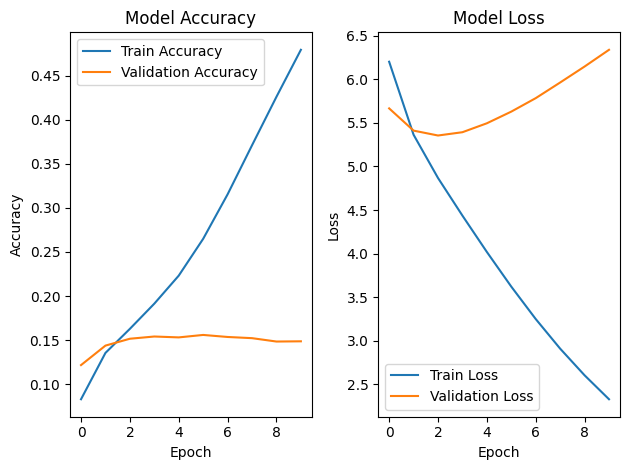

In [75]:
# early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    # callbacks=[early_stopping],
    verbose=1
)

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [76]:
val_loss = history.history['val_loss'][-1]
perplexity = np.exp(val_loss)

print(f"Validation Perplexity: {perplexity:.2f}")
# print(f"Training epochs before Early Stopping: {len(history.history['loss'])}")

Validation Perplexity: 565.17


## 6. Generation Criteria
- After training, generate **two distinct text samples**, each at least **50 tokens**.
- Use **different seed phrases** (e.g., “love is” vs. “time will”).

In [77]:
def generate_text(model, id_to_word, seed_text, sequence_length, num_tokens=50):
    input_sequence = [vocab.get(word, 0) for word in seed_text.split()]
    input_sequence = np.pad(input_sequence, (sequence_length - len(input_sequence), 0), mode="constant")
    generated_text = seed_text

    for _ in range(num_tokens):
        input_sequence_reshaped = np.reshape(input_sequence, (1, sequence_length))
        predicted_probs = model.predict(input_sequence_reshaped, verbose=0)
        predicted_token_id = np.argmax(predicted_probs)
        predicted_word = id_to_word.get(predicted_token_id, "")
        generated_text += " " + predicted_word
        input_sequence = np.append(input_sequence[1:], predicted_token_id)
    return generated_text

seed_phrase_1 = "she will not"
seed_phrase_2 = "the hero is"
num_tokens = 50

generated_text_1 = generate_text(model, id_to_word, seed_phrase_1, sequence_length=50, num_tokens=num_tokens)
generated_text_2 = generate_text(model, id_to_word, seed_phrase_2, sequence_length=50, num_tokens=num_tokens)

print("Generated Text 1:", generated_text_1)
print()
print("Generated Text 2:", generated_text_2)

Generated Text 1: she will not like you but i am not jealous. there is no one living who is absolutely again for i am exceedingly fond. i am not surprised the story of the gods for i want to know who are you talking about? that you are afraid of your father and mother both

Generated Text 2: the hero is going rags to the house of the bow. then he went to the house of the cloister where the suitors were camping in the house of the cloister and said to the suitors hear what we have come to the house of hades and king alcinous who was still furious


The perplexity is quite high for this model. This is likely due to the 4.6M trainable parameters of the model and the execution of a very simplistic training model for this data. Perhaps switching to tokenizing by character would result in a lower perplexity.